In [1]:
from call_functions import *
from scipy.integrate import odeint,complex_ode
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tikzplotlib

In [2]:
# ------------------------------
# Parameters to tune
# ------------------------------

x0 = 0
L = 2 * np.pi
Nx = 2**6 +1
Nf = Nx // 2
d = 1000*np.pi
dt = 1e-3
a = 2 * np.pi
g = 9.80665
gain = 1
T_start = 0
T = 200
N_ini_fq = 2**1

# ------------------------------
# Space discretization
# ------------------------------

dx = L / Nx
Lx = L - dx
xspan = np.arange(x0, Lx + dx, dx)
frequences = np.fft.fftfreq(Nx, dx) * 2 * np.pi
frequences2 = fftfreq(Nx, dx) * 2 * np.pi # same as above

# ------------------------------
# Time discretization
# ------------------------------

T_end = T_start + T
tspan = np.arange(T_start, T_end + dt, dt)
Nt = len(tspan)

# ------------------------------
# Matrix computations
# ------------------------------

# 1) DFT and iDFT Matrices (as well as no mean matrices)
DFT = 1 / Nx * getDFT(Nx)
iDFT = getiDFT(Nx)

# 2) True matrix A not in Fourier
O = np.zeros((Nx, Nx))
I = np.eye(Nx)
G = Matrix_A_dz(Nx, dx, d)
_, C = GetC(np.abs(xspan - np.pi) <= a)
B = np.block([[O,O],[O,-gain*C.T @ C]])
A = np.block([[O, -g*I], [G, O]])

# vector with list of all the positive frequencices
pos_frequences = frequences[1:int((len(frequences)-1)/2)+1]

# Matrix that deletes the mean
Pi_nm = iDFT @ np.diag(np.concatenate((np.zeros(1),np.ones(Nx-1)))) @ DFT

# Matrix that deletes the mean and the high frequencies
Pi_lf = iDFT @ np.diag(np.concatenate((np.zeros(1),(pos_frequences <= N_ini_fq),(pos_frequences <= N_ini_fq)[::-1]))) @ DFT
Pi_hf = iDFT @ np.diag(np.concatenate((np.zeros(1),(pos_frequences > N_ini_fq),(pos_frequences > N_ini_fq)[::-1]))) @ DFT

M = A+B

def func_M(y,t):
    return M @ y

In [5]:
def odeintz(func, z0, t, **kwargs):
    """An odeint-like function for complex valued differential equations."""

    # Disallow Jacobian-related arguments.
    _unsupported_odeint_args = ['Dfun', 'col_deriv', 'ml', 'mu']
    bad_args = [arg for arg in kwargs if arg in _unsupported_odeint_args]
    if len(bad_args) > 0:
        raise ValueError("The odeint argument %r is not supported by "
                         "odeintz." % (bad_args[0],))

    # Make sure z0 is a numpy array of type np.complex128.
    z0 = np.array(z0, dtype=np.complex128, ndmin=1)

    def realfunc(x, t, *args):
        z = x.view(np.complex128)
        dzdt = func(z, t, *args)
        # func might return a python list, so convert its return
        # value to an array with type np.complex128, and then return
        # a np.float64 view of that array.
        return np.asarray(dzdt, dtype=np.complex128).view(np.float64)

    result = odeint(realfunc, z0.view(np.float64), t, **kwargs)

    if kwargs.get('full_output', False):
        z = result[0].view(np.complex128)
        infodict = result[1]
        return z, infodict
    else:
        z = result.view(np.complex128)
        return z

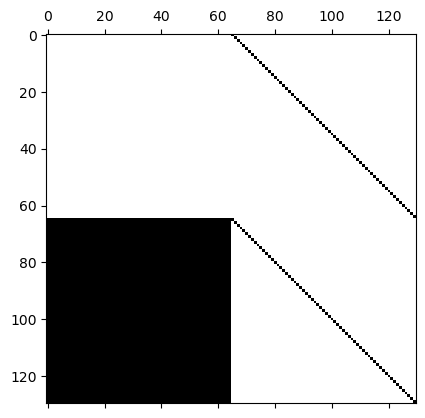

In [6]:
plt.spy(M)

In [7]:
eigval_M, eigvect_M = np.linalg.eig(M)

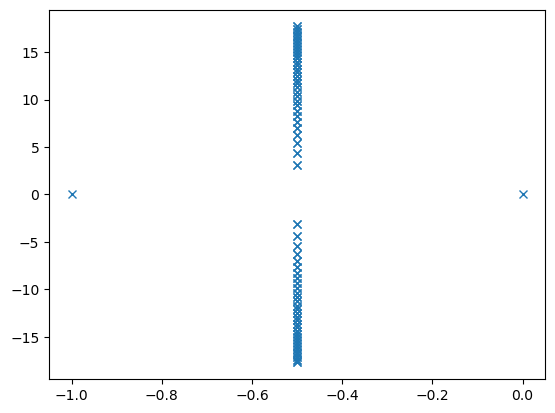

In [8]:
plt.plot(np.real(eigval_M),np.imag(eigval_M),'x')

In [9]:
eigval_M[np.real(eigval_M) > 0]

array([3.47012519e-14+0.j])

In [10]:
eta0 = np.sin(xspan)
phi0 = iDFT@(1j/g*DFT@eta0)*np.sqrt(g*np.abs(frequences)*np.tanh(d*np.abs(frequences)))
X0 = np.concatenate((phi0,eta0))

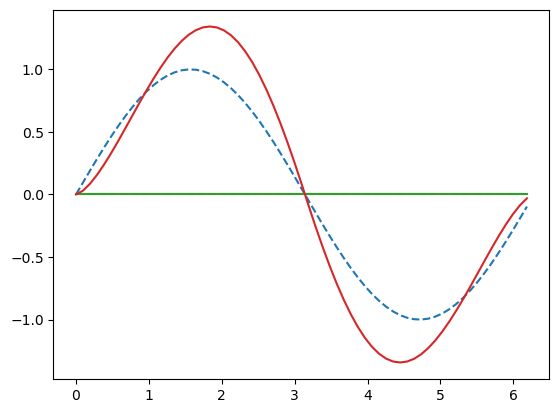

In [11]:
plt.plot(xspan,np.real(eta0),'--',xspan,np.imag(eta0),'--')
plt.plot(xspan,np.real(phi0),xspan,np.imag(phi0))

In [12]:
X_sol_EE_A_mix = odeint(func_M,X0,tspan)
print('1st edo : done')

TypeError: 'complex_ode' object is not callable

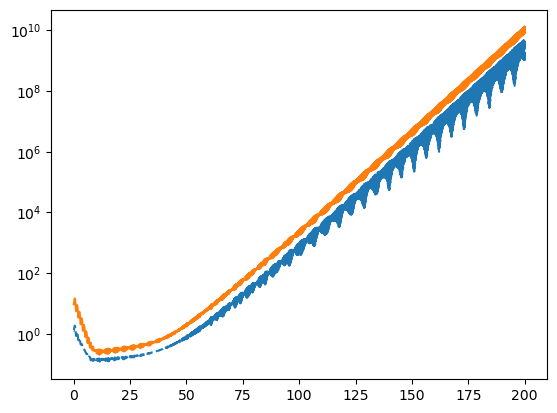

In [96]:
plt.semilogy(tspan,H_half_times_L2_norm(X_sol_EE_A_mix,Nx,dx),'--')
plt.semilogy(tspan,np.linalg.norm(X_sol_EE_A_mix,2,axis=0))